# Im2LaTeX: Seq2Seq with Attention

Установка зависимостей

In [44]:
!pip -q install datasets==2.18.0 sentencepiece==0.2.0

Импорты и гиперпараметры: все импорты, сиды, параметры модели/обучения и early stopping.

In [45]:
import math
import random
import re
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from datasets import load_dataset

SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMG_H = 64
IMG_W = 384
BATCH_SIZE = 32
MAX_TRAIN = 40000
MAX_VALID = 5000
MAX_LEN = 140
VOCAB_SIZE = 20000
EMB_DIM = 256
ENC_HID = 256
DEC_HID = 256
NHEAD = 8
DEC_LAYERS = 3
FF_DIM = 1024
DROPOUT = 0.3
N_EPOCHS = 70
PATIENCE = 5
MIN_DELTA = 0.0005
BEST_MODEL_PATH = "best_model.pt"

print("device:", device)


device: cuda


Загрузка датасета

In [68]:
DATASET_CANDIDATES = [
    "yuntian-deng/im2latex-100k",
    "im2latex-100k",
]
ds = None
last_err = None
for name in DATASET_CANDIDATES:
    try:
        ds = load_dataset(name)
        print("Loaded dataset:", name)
        break
    except Exception as e:
        last_err = e
        print("Failed to load", name, "error:", e)

if ds is None:
    raise last_err

print(ds)


Loaded dataset: yuntian-deng/im2latex-100k
DatasetDict({
    train: Dataset({
        features: ['formula', 'filename', 'image'],
        num_rows: 55033
    })
    test: Dataset({
        features: ['formula', 'filename', 'image'],
        num_rows: 6810
    })
    val: Dataset({
        features: ['formula', 'filename', 'image'],
        num_rows: 6072
    })
})


Определение ключей: находит поля изображения и формулы в примере.

In [47]:
example = ds["train"][0]
print(example.keys())

IMAGE_KEY = "image"
if IMAGE_KEY not in example:
    raise ValueError("Image key not found. Update IMAGE_KEY to match dataset columns.")

if "latex" in example:
    FORMULA_KEY = "latex"
elif "text" in example:
    FORMULA_KEY = "text"
elif "formula" in example:
    FORMULA_KEY = "formula"
else:
    raise ValueError("Formula key not found. Update FORMULA_KEY to match dataset columns.")

print("Using formula key:", FORMULA_KEY)


dict_keys(['formula', 'filename', 'image'])
Using formula key: formula


Сплиты и выборка: формирует train/val, ограничивает размер, собирает формулы.

In [48]:
train_ds = ds["train"].shuffle(seed=SEED)
if MAX_TRAIN:
    train_ds = train_ds.select(range(min(MAX_TRAIN, len(train_ds))))

if "validation" in ds:
    valid_split = "validation"
elif "val" in ds:
    valid_split = "val"
elif "test" in ds:
    valid_split = "test"
else:
    valid_split = "train"

valid_ds = ds[valid_split].shuffle(seed=SEED)
if MAX_VALID:
    valid_ds = valid_ds.select(range(min(MAX_VALID, len(valid_ds))))

train_formulas = [ex[FORMULA_KEY] for ex in train_ds]
print("valid split:", valid_split)


valid split: val


SentencePiece обучение: тренирует BPE/Unigram и загружает модель токенизатора.

In [49]:
import sentencepiece as spm

SP_MODEL_PREFIX = "im2latex_sp"
SP_VOCAB_SIZE = 1484
SP_MODEL_TYPE = "bpe"  # or 'unigram'

# Train on a sample of formulas to keep it fast on Colab
SP_TRAIN_MAX = min(20000, len(train_formulas))
sp_train_text = "\n".join(train_formulas[:SP_TRAIN_MAX])
with open("sp_train.txt", "w", encoding="utf-8") as f:
    f.write(sp_train_text)

spm.SentencePieceTrainer.train(
    input="sp_train.txt",
    model_prefix=SP_MODEL_PREFIX,
    vocab_size=SP_VOCAB_SIZE,
    model_type=SP_MODEL_TYPE,
    character_coverage=1.0,
    normalization_rule_name="identity",
    hard_vocab_limit=True,
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3,
)

sp = spm.SentencePieceProcessor()
sp.load(f"{SP_MODEL_PREFIX}.model")

PAD_IDX = sp.pad_id()
UNK_IDX = sp.unk_id()
BOS_IDX = sp.bos_id()
EOS_IDX = sp.eos_id()

print("SentencePiece vocab size:", sp.get_piece_size())


SentencePiece vocab size: 1484


Проверка UNK: оценивает долю *unk* на сэмпле.

In [50]:
# Estimate UNK rate on a small sample (SentencePiece)
sample_formulas = train_formulas[:1000]
tok_total = 0
tok_unk = 0
for f in sample_formulas:
    ids = sp.encode(f, out_type=int)
    tok_total += len(ids)
    tok_unk += sum(1 for i in ids if i == UNK_IDX)
unk_rate = tok_unk / max(1, tok_total)
print(f"UNK rate (sample): {unk_rate:.3f}")


UNK rate (sample): 0.000


Датасет и DataLoader: препроцессинг изображений, паддинг, загрузчики.

In [51]:
import torchvision.transforms.functional as TF

class Im2LatexDataset(Dataset):
    def __init__(self, hf_ds, max_len):
        self.ds = hf_ds
        self.max_len = max_len

    def encode(self, formula):
        ids = sp.encode(formula, out_type=int, add_bos=True, add_eos=True)
        ids = ids[: self.max_len]
        return torch.tensor(ids, dtype=torch.long)

    def _process_image(self, img):
        img = img.convert("L")
        w, h = img.size
        new_w = max(1, int(w * (IMG_H / h)))
        img = img.resize((new_w, IMG_H))
        if new_w < IMG_W:
            pad_right = IMG_W - new_w
            img = TF.pad(img, (0, 0, pad_right, 0), fill=255)
        elif new_w > IMG_W:
            img = TF.center_crop(img, (IMG_H, IMG_W))
        img = TF.to_tensor(img)
        return img

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = ex[IMAGE_KEY]
        img = self._process_image(img)
        formula = ex[FORMULA_KEY]
        token_ids = self.encode(formula)
        return img, token_ids

def collate_fn(batch):
    imgs, seqs = zip(*batch)
    imgs = torch.stack(imgs)
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    max_len = max(lengths).item()
    padded = torch.full((len(seqs), max_len), PAD_IDX, dtype=torch.long)
    for i, s in enumerate(seqs):
        padded[i, : len(s)] = s
    return imgs, padded, lengths

train_data = Im2LatexDataset(train_ds, MAX_LEN)
valid_data = Im2LatexDataset(valid_ds, MAX_LEN)

pin = torch.cuda.is_available()
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=pin,
    persistent_workers=False,
)

valid_loader = DataLoader(
    valid_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=pin,
    persistent_workers=False,
)

print("train batches:", len(train_loader), "valid batches:", len(valid_loader))


train batches: 1250 valid batches: 157


Модель: positional encoding, CNN‑encoder, Transformer‑decoder, сборка модели.

In [52]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return self.dropout(x)

class CNNEncoder(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),
        )
        self.fc = nn.Linear(256 * (IMG_H // 16), d_model)
        self.pos = PositionalEncoding(d_model, dropout=dropout)

    def forward(self, x):
        feats = self.cnn(x)
        b, c, h, w = feats.size()
        feats = feats.permute(0, 3, 1, 2).contiguous().view(b, w, c * h)
        feats = self.fc(feats)
        feats = self.pos(feats)
        return feats

class Seq2SeqTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, ff_dim, dropout):
        super().__init__()
        self.encoder = CNNEncoder(d_model, dropout)
        self.tok_emb = nn.Embedding(vocab_size, d_model, padding_idx=PAD_IDX)
        self.pos = PositionalEncoding(d_model, dropout=dropout)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=ff_dim, dropout=dropout, batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, vocab_size)
        self.d_model = d_model

    def _generate_square_subsequent_mask(self, sz, device):
        mask = torch.triu(torch.ones(sz, sz, device=device), diagonal=1).bool()
        return mask

    def encode(self, src):
        return self.encoder(src)

    def decode(self, tgt, memory):
        tgt_emb = self.tok_emb(tgt) * math.sqrt(self.d_model)
        tgt_emb = self.pos(tgt_emb)
        tgt_mask = self._generate_square_subsequent_mask(tgt.size(1), tgt.device)
        tgt_key_padding_mask = (tgt == PAD_IDX)
        out = self.decoder(
            tgt_emb,
            memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
        )
        return self.fc_out(out)

    def forward(self, src, trg):
        memory = self.encode(src)
        tgt_input = trg[:, :-1]
        return self.decode(tgt_input, memory)

    def decode_step(self, tgt_seq, memory):
        logits = self.decode(tgt_seq, memory)
        return logits[:, -1]

model = Seq2SeqTransformer(
    vocab_size=sp.get_piece_size(),
    d_model=EMB_DIM,
    nhead=NHEAD,
    num_layers=DEC_LAYERS,
    ff_dim=FF_DIM,
    dropout=DROPOUT,
).to(device)

print(model)


Seq2SeqTransformer(
  (encoder): CNNEncoder(
    (cnn): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Linear(in_features=1024, out_features=256, bias=True)
    (pos): PositionalEncoding(
      (dropout): Dropout(p=0.3, inplace=False)
    )
  )
  (tok_emb): Emb

Обучение/оценка: optimizer, loss, AMP, функции train_epoch и evaluate.

In [53]:
from tqdm.auto import tqdm

optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.1)
scaler = torch.amp.GradScaler(enabled=device.type == "cuda")

def train_epoch(model, loader, optimizer, criterion, clip, epoch=None):
    model.train()
    epoch_loss = 0.0
    for imgs, trg, _ in loader:
        imgs = imgs.to(device)
        trg = trg.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda", enabled=device.type == "cuda"):
            output = model(imgs, trg)
            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            trg_flat = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg_flat)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
    return epoch_loss / max(1, len(loader))

def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0.0
    with torch.no_grad():
        for imgs, trg, _ in loader:
            imgs = imgs.to(device)
            trg = trg.to(device)
            output = model(imgs, trg)
            output_dim = output.shape[-1]
            output = output.reshape(-1, output_dim)
            trg_flat = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg_flat)
            epoch_loss += loss.item()
    return epoch_loss / max(1, len(loader))


### Цикл обучения: ранняя остановка, сохранение лучшей модели, лог по эпохам.

In [54]:
from tqdm.auto import tqdm

best_valid = float("inf")
epochs_no_improve = 0

epoch_bar = tqdm(range(1, N_EPOCHS + 1), desc="Epochs", position=0)
for epoch in epoch_bar:
    train_loss = train_epoch(model, train_loader, optimizer, criterion, clip=1.0, epoch=epoch)
    valid_loss = evaluate(model, valid_loader, criterion)
    if valid_loss < best_valid - MIN_DELTA:
        best_valid = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), BEST_MODEL_PATH)
    else:
        epochs_no_improve += 1
    epoch_bar.set_postfix(train=f"{train_loss:.4f}", valid=f"{valid_loss:.4f}", best=f"{best_valid:.4f}")
    tqdm.write(f"epoch {epoch}: train {train_loss:.4f} | valid {valid_loss:.4f}")
    if epochs_no_improve >= PATIENCE:
        tqdm.write("Early stopping triggered.")
        break


Epochs:   0%|          | 0/70 [00:00<?, ?it/s]

epoch 1: train 3.1856 | valid 2.8431
epoch 2: train 2.8036 | valid 2.5328
epoch 3: train 2.5626 | valid 2.3313
epoch 4: train 2.3605 | valid 2.0678
epoch 5: train 2.2002 | valid 1.9217
epoch 6: train 2.0750 | valid 1.8202
epoch 7: train 1.9796 | valid 1.7638
epoch 8: train 1.9050 | valid 1.6764
epoch 9: train 1.8456 | valid 1.6254
epoch 10: train 1.7968 | valid 1.6291
epoch 11: train 1.7579 | valid 1.5811
epoch 12: train 1.7235 | valid 1.5559
epoch 13: train 1.6954 | valid 1.5439
epoch 14: train 1.6693 | valid 1.5214
epoch 15: train 1.6478 | valid 1.5236
epoch 16: train 1.6281 | valid 1.5082
epoch 17: train 1.6085 | valid 1.4916
epoch 18: train 1.5933 | valid 1.4807
epoch 19: train 1.5784 | valid 1.4717
epoch 20: train 1.5658 | valid 1.4546
epoch 21: train 1.5529 | valid 1.4698
epoch 22: train 1.5407 | valid 1.4844
epoch 23: train 1.5300 | valid 1.4570
epoch 24: train 1.5215 | valid 1.4471
epoch 25: train 1.5116 | valid 1.4356
epoch 26: train 1.5033 | valid 1.4223
epoch 27: train 1.494

### Визуализация

In [57]:
import math

def beam_search_decode(model, src, max_len, beam_size=10, length_penalty=0.8):
    model.eval()
    with torch.no_grad():
        memory = model.encode(src)
        batch_size = src.size(0)
        results = []
        for b in range(batch_size):
            beams = [(0.0, [BOS_IDX])]
            for _ in range(max_len):
                new_beams = []
                for score, seq in beams:
                    if seq[-1] == EOS_IDX:
                        new_beams.append((score, seq))
                        continue
                    tgt = torch.tensor([seq], device=src.device)
                    logits = model.decode_step(tgt, memory[b:b+1])
                    log_probs = torch.log_softmax(logits, dim=1).squeeze(0)
                    topk = torch.topk(log_probs, beam_size)
                    for i in range(beam_size):
                        tok = topk.indices[i].item()
                        tok_score = topk.values[i].item()
                        new_seq = seq + [tok]
                        new_score = score + tok_score
                        new_beams.append((new_score, new_seq))
                beams = sorted(
                    new_beams,
                    key=lambda x: x[0] / (len(x[1]) ** length_penalty),
                    reverse=True,
                )[:beam_size]
                if all(seq[-1] == EOS_IDX for _, seq in beams):
                    break
            best_seq = max(beams, key=lambda x: x[0] / (len(x[1]) ** length_penalty))[1]
            results.append(best_seq)
        return results

def decode_ids(ids):
    ids = [i for i in ids if i not in (BOS_IDX, PAD_IDX, EOS_IDX)]
    return sp.decode(ids)

model.eval()
imgs, trg, _ = next(iter(valid_loader))
imgs = imgs.to(device)
preds = beam_search_decode(model, imgs[:5], max_len=MAX_LEN, beam_size=7)

for i in range(len(preds)):
    gt = decode_ids(trg[i].tolist())
    pr = decode_ids(preds[i])
    print("GT:", gt)
    print("PR:", pr)
    print("-" * 40)


GT: \left. \tilde { S } _ { \mathrm { \scriptsize ~ r e d } } ( \hat { \xi } ( p ) , \hat { \eta } ( p ) ) = S _ { \mathrm { \scriptsize ~ e f f } } ( \hat { \xi } , \hat { \eta } ) \right| _ { \hat { \xi } ( p ) = \hat { \eta } ( p ) = 0 \atop { | p | > \Lambda } } .
PR: \tilde { S } _ { \mathrm { r e d } } ( \hat { \xi } ( p ) , \hat { \eta } ( p ) ) = S _ { \mathrm { e f f f } } ( \hat { \xi } , \hat { \eta } ) \right| _ { \hat { \zeta } _ { ( p ) = 0 } ^ { ( \hat { \hat { \xi } , \hat { \eta } ) } _ { \hat { \hat { \imath } ( p ) = 0 } _ { ( p ) = 0 } , \hat { \hat { \hat { \
----------------------------------------
GT: \psi _ { 2 } \equiv A _ { 2 } \left[ I _ { 2 1 } - I _ { 2 2 } \right] .
PR: \psi _ { 2 } \equiv A _ { 2 } \left[ I _ { 2 1 } - I _ { 2 2 2 } \right] .
----------------------------------------
GT: \frac { \alpha ^ { \prime } } 2 M ^ { 2 } = \frac { ( w R ) ^ { 2 } } { 2 \alpha ^ { \prime } } - 1 .
PR: \frac { \alpha ^ { \prime } } { 2 } M ^ { 2 } = \frac { ( w R ) ^

<IPython.core.display.Javascript object>


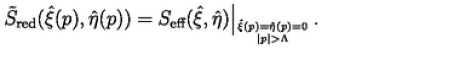
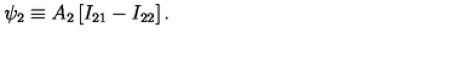
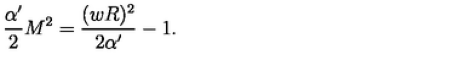
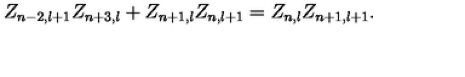
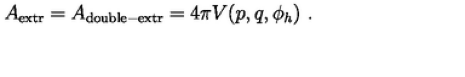

<IPython.core.display.Javascript object>

In [67]:
import re
import base64
from io import BytesIO
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Javascript

# Load MathJax once (with LEFT alignment for display math)
display(Javascript(r"""
(function() {
  if (window.__im2latex_mj_loaded) return;
  window.__im2latex_mj_loaded = true;

  window.MathJax = {
    tex: { inlineMath: [['\\(','\\)']], displayMath: [['\\[','\\]']], processEscapes: true },
    chtml: { displayAlign: 'left', displayIndent: '0em' },   // <-- ключевое
    options: { skipHtmlTags: ['script','noscript','style','textarea','pre','code'] }
  };

  var script = document.createElement('script');
  script.src = 'https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js';
  script.async = true;
  document.head.appendChild(script);
})();
"""))

def _join_spaced_letters(text: str) -> str:
    text = re.sub(r'\s*-\s*', '-', text)
    text = re.sub(r'(?:(?<=\s)|^)([A-Za-z])(?:\s+([A-Za-z])){2,}(?=\s|$)',
                  lambda m: re.sub(r'\s+', '', m.group(0)), text)
    return text

def sanitize_latex(s: str) -> str:
    s = s.strip()
    for cmd in [r'\scriptsize', r'\tiny', r'\small', r'\normalsize', r'\large', r'\Large', r'\LARGE']:
        s = s.replace(cmd, '')
    s = s.replace(r'\left.', '')
    s = s.replace(r'\right|', '|')
    s = s.replace(r'\left', '')
    s = s.replace(r'\right', '')
    s = s.replace(r'\atop', r'\over')
    s = s.replace('~', ' ')
    s = re.sub(r'\s+', ' ', s)
    s = _join_spaced_letters(s)
    return s.strip()

def fig_to_base64(img_2d):
    fig, ax = plt.subplots(figsize=(6, 1.8))
    ax.imshow(img_2d, cmap="gray")
    ax.axis("off")
    buf = BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight", pad_inches=0)
    plt.close(fig)
    return base64.b64encode(buf.getvalue()).decode("ascii")

def show_predictions_rendered(model, loader, n=5, beam_size=7):
    model.eval()
    imgs, trg, _ = next(iter(loader))
    imgs = imgs.to(device)
    preds = beam_search_decode(model, imgs[:n], max_len=MAX_LEN, beam_size=beam_size)

    container_id = "im2latex_vis_container"

    css = """
    <style>
      .card { margin:12px 0 18px 0; padding:12px; border:1px solid #ddd; border-radius:12px; }
      .title { font-weight:700; margin-bottom:10px; }
      .grid { display:grid; grid-template-columns: 360px 1fr; gap:14px; align-items:start; }
      .imgwrap img { width:100%; height:auto; border:1px solid #eee; border-radius:8px; background:#fff; }
      .block { margin-top:8px; }
      .lbl { font-weight:800; margin-bottom:6px; }
      .math { text-align:left; overflow-x:auto; padding:8px 10px; border:1px solid #eee; border-radius:8px; background:#fafafa; color: #111; }
      /* заставляем MathJax display-формулы быть слева */
      .math mjx-container[jax="CHTML"][display="true"] { text-align:left !important; margin:0 !important; }
      details { margin-top:10px; }
      pre.raw { white-space:pre-wrap; background:#0b0b0b10; border:1px solid #eee; padding:10px; border-radius:8px; }
    </style>
    """

    parts = [css, f"<div id='{container_id}' style='max-width:1100px;'>"]

    for i in range(n):
        img = imgs[i].detach().cpu().squeeze(0).numpy()
        img_b64 = fig_to_base64(img)

        gt_raw = decode_ids(trg[i].tolist())
        pr_raw = decode_ids(preds[i])
        gt = sanitize_latex(gt_raw)
        pr = sanitize_latex(pr_raw)

        parts.append(f"""
        <div class="card">
          <div class="title">Example {i} | beam={beam_size}</div>
          <div class="grid">
            <div class="imgwrap">
              <img src="data:image/png;base64,{img_b64}" />
            </div>
            <div>
              <div class="block">
                <div class="lbl">GT</div>
                <div class="math">\\[{gt}\\]</div>
              </div>
              <div class="block">
                <div class="lbl">PR</div>
                <div class="math">\\[{pr}\\]</div>
              </div>

              <details>
                <summary style="cursor:pointer;">Show raw text</summary>
                <pre class="raw">GT RAW: {gt_raw}\n\nPR RAW: {pr_raw}</pre>
              </details>
            </div>
          </div>
        </div>
        """)

    parts.append("</div>")
    display(HTML("".join(parts)))

    # Wait for MathJax and typeset only our container
    display(Javascript(f"""
    (function() {{
      const container = document.getElementById('{container_id}');
      if (!container) return;

      function typesetWhenReady(tries) {{
        if (window.MathJax && MathJax.typesetPromise) {{
          MathJax.typesetClear([container]);
          MathJax.typesetPromise([container]);
          return;
        }}
        if (tries <= 0) return;
        setTimeout(() => typesetWhenReady(tries - 1), 250);
      }}
      typesetWhenReady(40);
    }})();
    """))

show_predictions_rendered(model, valid_loader, n=5, beam_size=7)


**Example 0**

Начало очень хорошее: правильно восстановлены \tilde S, red, аргументы (\hat\xi(p), \hat\eta(p)), знак равенства и S_eff/efff (почти).
Дальше модель ломается на части с ограничением \right|_{ ... \atop ... }:

начинает генерировать мусорные вложенные \hat{...}

строка обрывается (невалидный LaTeX)

Итог:
- Основная “левая часть” распознана.
- “Условие справа” (подстрочник/ограничение) — самое сложное место, тут пока слабее.
- Тип ошибки: нестабильность декодирования + сложная разметка (\right|_{... \atop ...}).

**Example 1**

Что произошло:
Всё распознано верно, кроме одного символа: повторилась цифра 2 в индексе.

Итог:
- Почти идеал.
- Небольшой “повтор токена” (частая проблема beam/декодера).

**Example 2**

Что совпало:
Правая часть совпала полностью.
Символы \alpha', (wR)^2, -1 — всё верно.

Что не совпало:
В левой части ошибка группировки знаменателя:

GT: знаменатель = 2 M^2

PR: знаменатель = 2, а M^2 вынесено наружу

Итог:
- Супер-близко по смыслу.
- Ошибка “скобок/группировки” (структурная, но небольшая).

**Example 3**

Что совпало:
 Первая часть произведения  — верная.
 Общая форма “сумма произведений” — узнаётся.

Потери/ошибки:
Утерян индекс ,l у Z_{n+1,l} → стало Z_{n+1}
Правая часть сильно “схлопнулась”: вместо Z_{n,l}Z_{n+1,l+1} получилось просто Z_{n,l+1}

Итог:
- Это уже заметная потеря части выражения.
- Тип ошибки: модель выбирает более короткую/простую гипотезу (часто лечится beam + length penalty / no-repeat / чуть лучшим encoder-ом).

**Example 4**

PR: полностью совпадает с GT.

Итог:
- Идеально. Причём это важно: тут есть текстовые куски double-extr, extr, \mathrm{...} — и модель справилась.

### Общий вывод



В ходе работы была реализована и исследована нейросетевая система для задачи распознавания математических формул (Image-to-LaTeX) на основе датасета im2latex. Модель построена в архитектуре CNN-энкодер + Transformer-декодер с использованием SentencePiece (BPE) для токенизации и beam search для декодирования.

По результатам обучения достигнуто стабильное снижение функции потерь:
valid loss ≈ 1.34, что соответствует высокому уровню качества для компактной модели, обученной в среде Google Colab Free. Визуальный анализ предсказаний показал, что система уверенно восстанавливает структуру формул (дроби, индексы, скобки, математические операторы) и во многих случаях полностью совпадает с эталонной разметкой.

Основные ошибки связаны с:

редкими символами и мелким текстом внутри формул,

повторениями токенов при декодировании,

сложными конструкциями вида \left...\right|_{...}.

В целом модель демонстрирует способность не только воспроизводить синтаксис LaTeX, но и извлекать семантические паттерны из изображений формул.